**Sentiment Analysis of Movie Reviews**

In [ ]:
from collections import Counter # Counter() is a dict for counting
import numpy as np
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

Run parameters

In [2]:
stop_list = False
lemmatize = False
three_sentiment = True # change this to True to get three sentiment, change to False to get five sentiment

Load train set

In [3]:
train = pd.read_csv("train.tsv", sep='\t', index_col=0)
train['Phrase'] = train['Phrase'].str.lower()  # change to lowercase
train['Phrase'] = train['Phrase'].str.replace('[,.:;\'`-]','', regex=True) 

In [4]:
if stop_list:
  nlp = spacy.load('en')
  stopwords = list(STOP_WORDS)
  train['Phrase']= train['Phrase'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [5]:
def three_value_sentiment_024(ar):
  if ar['Sentiment'] == 0 or ar['Sentiment'] == 1:
    return 0
  elif ar['Sentiment'] == 2:
    return 2
  elif ar['Sentiment'] == 3 or ar['Sentiment'] == 4:
    return 4
    
if three_sentiment:
  train['Sentiment'] = train.apply(three_value_sentiment_024, axis=1)

In [6]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in text.split(' ')])

if lemmatize:
  train['Phrase'] = train.Phrase.apply(lemmatize_text)

Count class occurances

In [7]:
negative_count = train[train.Sentiment == 0].shape[0]
some_negative_count = train[train.Sentiment == 1].shape[0]
neutral_count = train[train.Sentiment == 2].shape[0]
some_positive_count = train[train.Sentiment == 3].shape[0]
positive_count = train[train.Sentiment == 4].shape[0]

Posterior probabilites for 3 sentiment

In [8]:
def posterior_probabilities():
  negative = negative_count/ train.shape[0]
  som_negative = some_negative_count/ train.shape[0]
  neutral = neutral_count / train.shape[0]
  som_positive = some_positive_count / train.shape[0]
  positive = positive_count / train.shape[0]
  return negative, som_negative, neutral, som_positive, positive

posterior_negative, posterior_som_negative, posterior_neutral, posterior_som_positive, posterior_positive  = posterior_probabilities()

Create features dictionary

In [9]:
# Dictionaries to keep word occurances for each class
like_neg = Counter(); 
like_som_neg = Counter();
like_neu = Counter(); 
like_som_pos = Counter(); 
like_pos = Counter();

# Word counters for each class
neg_count = 0
som_neg_count = 0
neu_count = 0
som_pos_count = 0
pos_count = 0

vocabulary = set()

for tweet, sentiment in train.itertuples(index=False):
    words = tweet.strip().split()
    if sentiment == 0:
      occ_counts = like_neg
      neg_count += len(words)
    elif sentiment == 1:
      occ_counts = like_som_neg
      som_neg_count += len(words)
    elif sentiment == 2:
      occ_counts = like_neu
      neu_count += len(words)
    elif sentiment == 3:
      occ_counts = like_som_pos
      som_pos_count += len(words)
    elif sentiment == 4:
      occ_counts = like_pos
      pos_count += len(words)

    for word in words:
      occ_counts[word] += 1 # Store occurence counts for all words
      vocabulary.add(word)

Likelihoods for features (dont run multiple times)

In [10]:
vocab_len = len(vocabulary)
def calculate_likelihoods(ar, n):
  for word in ar:
    ar[word] = (ar[word] + 1)/ (n + vocab_len)

calculate_likelihoods(like_neg, neg_count)
calculate_likelihoods(like_som_neg, som_neg_count)
calculate_likelihoods(like_neu, neu_count)
calculate_likelihoods(like_som_pos, som_pos_count)
calculate_likelihoods(like_pos, pos_count)

def calculate_default_likelihoods(n):
    return 1/(n + vocab_len)

default_like_neg = calculate_default_likelihoods(neg_count)
default_like_som_neg = calculate_default_likelihoods(som_neg_count)
default_like_neu = calculate_default_likelihoods(neu_count)
default_like_som_pos = calculate_default_likelihoods(som_pos_count)
default_like_pos = calculate_default_likelihoods(pos_count)

Load dev set

In [11]:
dev = pd.read_csv("dev.tsv", sep='\t', index_col=0)
dev['Phrase'] = dev['Phrase'].str.lower()  # change to lowercase
dev["Phrase"] = dev['Phrase'].str.replace('[,.:;\'`-]','', regex=True)
if stop_list:
  dev['Phrase']= dev['Phrase'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

Use model on dev set

In [12]:
result = []

for id, tweet, s in dev.itertuples():
  words = tweet.strip().split()
  result_neg = posterior_negative
  result_som_neg = posterior_som_negative  
  result_neu = posterior_neutral
  result_pos = posterior_positive
  result_som_pos = posterior_som_positive

  def calculate_final_posterior(ar, token, default):
    if token in ar:
      return ar[token]
    else:
      return default

  for token in words:
    result_pos *= calculate_final_posterior(like_pos, token, default_like_pos)
    result_som_pos *= calculate_final_posterior(like_som_pos, token, default_like_som_pos)
    result_neu *= calculate_final_posterior(like_neu, token, default_like_neu)
    result_som_neg *= calculate_final_posterior(like_som_neg, token, default_like_som_neg)
    result_neg *= calculate_final_posterior(like_neg, token, default_like_neg)

  score_max = max(result_neg, result_som_neg, result_neu, result_som_pos, result_pos)

  if (score_max == result_neg):
    result.append([id, 0])
  elif (score_max == result_som_neg):
    result.append([id, 1])
  elif (score_max == result_neu):
    if(three_sentiment):
      result.append([id, 1])
    else:
      result.append([id, 2])
  elif (score_max == result_som_pos):
    result.append([id, 3])
  elif (score_max == result_pos):
    if(three_sentiment):
      result.append([id, 2])
    else:
      result.append([id, 4])

Write to result file

In [13]:
result_df = pd.DataFrame(result, columns=['SentenceId', 'Sentiment'])
result_df.set_index('SentenceId', inplace=True)
result_df.to_csv('result.tsv', sep='\t')

Evaluate

In [14]:
def three_value_sentiment_012(ar):
  if ar['Sentiment'] == 0 or ar['Sentiment'] == 1:
    return 0
  elif ar['Sentiment'] == 2:
    return 1
  elif ar['Sentiment'] == 3 or ar['Sentiment'] == 4:
    return 2

if (three_sentiment):
  dev['Sentiment'] = dev.apply(three_value_sentiment_012, axis=1)

Macro-F1

In [15]:
if three_sentiment:
  cm = np.zeros((3,3))
else:
  cm = np.zeros((5,5))

def calculate_tp_fp_fn(sentiment):
  tp = fp = fn = 0 
  for id, p, sentiment in dev[dev.Sentiment == sentiment].itertuples():
    cm[sentiment][result_df.loc[id, 'Sentiment']] += 1
    if sentiment == result_df.loc[id, 'Sentiment']:
      tp += 1
    else:
      fp += 1
  fn = result_df[result_df.Sentiment == sentiment].shape[0] - tp
  return tp, fp, fn

def calculate_f1(sentiment):
  tp, fp, fn = calculate_tp_fp_fn(sentiment)
  if (2 * tp + fp + fn) == 0:
    return 0
  f1 = (2 * tp) / (2 * tp + fp + fn)
  return f1

def calculate_macro_f1():
  m_f1 = 1
  sentiment_count = 5
  if three_sentiment:
    sentiment_count = 3
  for i in range (0,5):
      m_f1 += calculate_f1(i)
  return m_f1/sentiment_count

print(calculate_macro_f1())

0.8563840789811455


In [16]:
correct = 0
incorrect = 0
for id, p, s in dev.itertuples():
  if s == result_df.loc[id, 'Sentiment']:
      correct += 1
  else:
      incorrect += 1
print(correct)

649


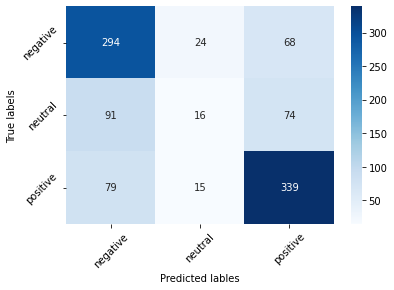

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cm, annot=True,cmap='Blues', fmt='g')
plt.xlabel("Predicted lables")
plt.ylabel("True labels")
if three_sentiment:
  ax.set(xticklabels=['negative', 'neutral', 'positive'])
  ax.set(yticklabels=['negative', 'neutral', 'positive'])
else:
  ax.set(xticklabels=['negative', 'somewhat\nnegative', 'neutral', 'somewhat\npositive', 'positive'])
  ax.set(yticklabels=['negative', 'somewhat\nnegative', 'neutral', 'somewhat\npositive', 'positive'])

sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(8,6)})
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [18]:
# https://www.researchgate.net/publication/306364792_On_stopwords_filtering_and_data_sparsity_for_sentiment_analysis_of_twitter

# Thank you.